Simulations

In [1]:
import numpy as np
import pandas as pd
import AgentClass
import const
import random
import networkx as nx
from config import num_agents,number_of_bits
from scipy import stats
from collections import defaultdict
import json
import utilities

import matplotlib.pyplot as plt
%matplotlib inline
from IPython.core.pylabtools import figsize
import matplotlib
import seaborn as sns

import pymc3 as pm

import arviz as az

from IPython.display import display_html

import theano
import theano.tensor as T

In [2]:
sns.set(style='darkgrid', rc={'figure.figsize':(10,6)}, font_scale=1.25)

In [3]:
def get_tau_distr():
    lower = 0
    upper = 1
    mu = 0.5
    sigma = 0.1
    N = 1000

    samples = stats.truncnorm.rvs(
          (lower-mu)/sigma,(upper-mu)/sigma,loc=mu,scale=sigma,size=N)

    return samples

In [4]:
def create_environment():
    list_agents = []
    tau_distr = get_tau_distr()

    for i in range(num_agents):
        in_state = np.random.randint(2, size=number_of_bits).tolist()
        a = AgentClass.Agent(name='agent{}'.format(i), tau=random.choice(tau_distr), initial_state=in_state)
        list_agents.append(a)

    # create network
    G = nx.newman_watts_strogatz_graph(num_agents, 5, 0.5, seed= 0)
#    nx.draw(G, with_labels=True, font_weight='bold') # to draw agents
    df = nx.to_pandas_adjacency(G, dtype=int)

    tmp_edges = df.apply(lambda row: row.to_numpy().nonzero()).to_dict()
    edges = {k: v[0].tolist() for k, v in tmp_edges.items()}

    # make random connections with agents
    for k, v in edges.items():
        for ngh in v:
            list_agents[k].add_neighbors(list_agents[ngh])

    return list_agents

In [5]:
def get_network_df(list_agents):
    network_df = pd.DataFrame({'Agent Name':[], 'Neighbors':[]})
    for agt in list_agents:
        neighbors = agt.get_neighbors_name()
        network_df = network_df.append({'Agent Name':agt.name,
                                        'Neighbors':neighbors}, ignore_index=True)
    return network_df

In [6]:
def run_simulation(alpha, const:const.Constants, list_agents, end_time):
    d = []
    generations = 0
    for t in range(end_time):
        # compute next state for all agents
        for agt in list_agents:
            agt.update_knowledge(alpha, const.coh_transition_matrix, const.bit_matrix)

        # keep record of current record and all other values
        for agt in list_agents:
            row = {'Agent_Number': int(agt.name.split('t')[1]),
                   'Time':t,
                   # at any time step we will need normalized how many neighbors disagree on bits
                   'bits_disagreement':np.array(agt.state_disagreements),
                   'Current_Knowledge_State':agt.knowledge_state,
                   'Current': utilities.bool2int(agt.knowledge_state),
                   'alpha':alpha,
                   'Next': utilities.bool2int(agt.next_state),
                   'Next_Knowledge_State':agt.next_state}

            d.append(row)

        # now update all agents next state with computed next state
        for agt in list_agents:
            agt.knowledge_state = agt.next_state
            agt.next_state = None
            agt.dissonance_lst = None

        generations+=1
#         if generations%10 == 0:
#             print("alpha = {}; {} generations".format(alpha,generations))

    return pd.DataFrame(d)

In [7]:
def display_side_by_side(*args):
    """This function is only for viewing two dataframe side by side
    It helps to compare how the distributions are in original and sampled traces for now
    Reference: https://stackoverflow.com/a/44923103/5916727"""
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)

## Running simulation for generating data
> alpha = 0.1 <br>
> number of agents were set to 100 in config file <br>
> experiment time is only 1 currently, we may want to check with different random seed <br>
> coherence matrix is created with alpha_d value set to **alpha_d $\rightarrow$ .001** this will effect results coherence matrix <br>
> each agent moves for 100 steps starting from t=0 $\rightarrow$ t=99

In [8]:
### This cell is for generating the dataset
# constants intialization
end_simulation_time = 100
alphas = [0.5] 
exp_times = 1

# first create environment
agents_list = create_environment()

# get network of the agents
agent_network_df = get_network_df(agents_list)
constants = const.Constants()

coherence_matrix = constants.get_coh_tx_matrix().tolist()

# for saving the network of agents
# agent_network_df.to_json('test_network.json',orient='records', lines=True)
record_df = pd.DataFrame()
for i in range(exp_times):
    # run simulation
    for alpha in alphas:

        tmp_record_df = run_simulation(alpha, constants, agents_list, end_simulation_time)
        record_df = record_df.append(tmp_record_df)

Viewing how coherence matrix that generated data:

In [9]:
record_df.head()

,Agent_Number,Time,bits_disagreement,Current_Knowledge_State,Current,alpha,Next,Next_Knowledge_State
0,0,0,"[0.2, 0.2, 0.4, 0.4]","[1, 0, 0, 0]",1,0.5,10,"[0, 1, 0, 1]"
1,1,0,"[0.6666666666666666, 0.3333333333333333, 0.5, ...","[0, 0, 0, 1]",8,0.5,10,"[0, 1, 0, 1]"
2,2,0,"[0.2, 0.6, 0.8, 0.4]","[1, 0, 1, 1]",13,0.5,3,"[1, 1, 0, 0]"
3,3,0,"[0.14285714285714285, 0.7142857142857143, 0.57...","[1, 1, 1, 1]",15,0.5,3,"[1, 1, 0, 0]"
4,4,0,"[0.42857142857142855, 0.42857142857142855, 0.7...","[1, 1, 0, 1]",11,0.5,15,"[1, 1, 1, 1]"


In [10]:
record_df.shape

(5000, 8)

In [11]:
record_df['bits_disagreement'][0]

array([0.2, 0.2, 0.4, 0.4])

In [12]:
coh_matrix_df = pd.DataFrame(coherence_matrix)
coh_matrix_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0.000000,0.000000,0.000000,0.000000,0.362204,0.000000,0.000000,0.000000,0.000000,0.000000,0.637796,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.132646,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.867354,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.001485,0.002934,0.494507,0.501074,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.007498,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.004056,0.057333,0.058721,0.000000,0.872392,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.943970,0.000000,0.027364,0.000000,0.000000,0.000000,0.000000,0.000000,0.028666,0.000000
5,0.000000,0.000000,0.811847,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.188153,0.000000,0.000000,0.000000
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.000000,0.000000,0.797646,0.000000,0.000000,0.000000,0.000000,0.000000,0.036800,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.165554
8,0.000000,0.182921,0.000000,0.000000,0.000000,0.000000,0.000000,0.324525,0.000000,0.000000,0.089026,0.000000,0.000000,0.000000,0.000000,0.403528
9,0.000000,0.000000,0.003255,0.000000,0.000000,0.897128,0.084692,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.014925


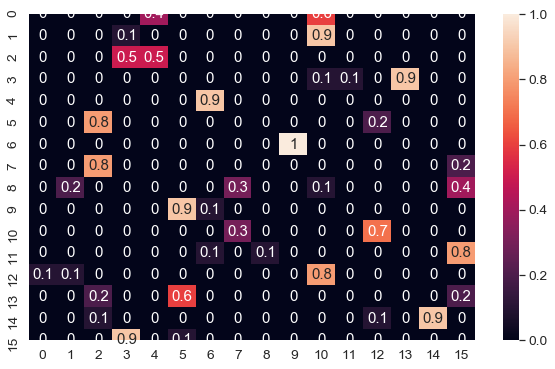

In [16]:
sns.heatmap(round(coh_matrix_df,1), annot=True);

# Using pyMC3

Using pymc3 MCMC sampling to estimate parameters, for now we only estimate probability of state transitions given a selected state

In [17]:
k = 2**number_of_bits # this is number of possible states 
# bits disagreement of all datasite for a given alpha value
bits_disagreement = np.asarray(record_df['bits_disagreement'].tolist())
agents_number_list = np.asarray(record_df['Agent_Number'].tolist())
current_knowledge_state = np.asarray(record_df['Current_Knowledge_State'].tolist())
current_state = np.asarray(record_df['Current'].tolist())

y = np.asarray(record_df['Next'].tolist()) # this is the next state values for each data from simulations
y_hot = np.eye(k)[y] # we changed above state values to one hot encoding

In [18]:
bit_m = np.asarray(constants.bit_matrix)
pd.DataFrame(bit_m) # just binary values of each state is corresponding to each rows

,0,1,2,3
0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0
3,1.0,1.0,0.0,0.0
4,0.0,0.0,1.0,0.0
5,1.0,0.0,1.0,0.0
6,0.0,1.0,1.0,0.0
7,1.0,1.0,1.0,0.0
8,0.0,0.0,0.0,1.0
9,1.0,0.0,0.0,1.0


In [19]:
with pm.Model() as model:
   
    agent_tau_vec = pm.Bound(pm.Normal, lower=0, upper=1.0)('tau', mu=0.5, sigma=0.1, shape=num_agents)
    a = np.ones(k) 
    alpha_est=pm.Uniform('alpha', 0, 1)
    a = np.ones(k) 
    theta = pm.Dirichlet("theta", a=a, shape=(k,k))    
    
    tau_vals = agent_tau_vec[agents_number_list]
    reshape_tau_vals = tau_vals.reshape((-1, 1))
    r = 1 / (1 + pm.math.exp(-8*(bits_disagreement-reshape_tau_vals)))
    ones_l = abs(r-current_knowledge_state)
    zeros_l = 1-ones_l
    ones_l_transfromed =  ones_l.reshape((-1, 1, number_of_bits))
    zeros_l_transfromed =  zeros_l.reshape((-1, 1, number_of_bits))

    ones_l_states = ones_l_transfromed*bit_m 
    zeros_l_states = zeros_l_transfromed*(1-bit_m) 
    sum_val = ones_l_states + zeros_l_states
    bitm_reshape = sum_val.reshape((-1, 2**number_of_bits, number_of_bits))

    tmp_soc_mat = bitm_reshape.prod(axis=2)
    coherence = theta[current_state]
    tmp_par = alpha_est*tmp_soc_mat + (1-alpha_est)*coherence


    results = pm.Multinomial("results",  n=1, p=tmp_par, observed=y_hot, shape=16)

C:\Users\niraj\AppData\Local\Continuum\anaconda3\envs\probabilistic\lib\site-packages\theano\tensor\subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


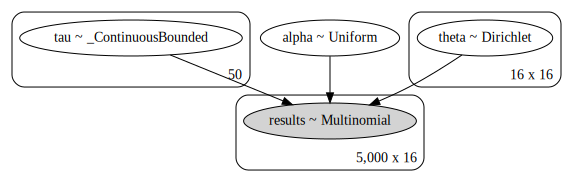

In [20]:
pm.model_to_graphviz(model)

In [21]:
with model:
    trace = pm.sample(draws=1000, cores=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [theta, alpha, tau]
100%|██████████████████████████████████████████████████████████████████████████████| 1500/1500 [05:39<00:00,  4.78it/s]


In [22]:
trace_df = pm.summary(trace).round(4)[['mean']]
trace_df

C:\Users\niraj\AppData\Local\Continuum\anaconda3\envs\probabilistic\lib\site-packages\pymc3\stats.py:991: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  axis=1, join_axes=[dforg.index])


,mean
tau__0,0.4719
tau__1,0.4680
tau__2,0.4893
tau__3,0.6234
tau__4,0.3743
...,...
theta__15_11,0.0069
theta__15_12,0.0387
theta__15_13,0.0065
theta__15_14,0.0059


In [23]:
actual_agents_tau = pd.DataFrame([a.tau for a in agents_list])
actual_agents_tau.columns = ['Actual Tau']

In [34]:
trace_mean_tau = pd.DataFrame(trace['tau'].mean(axis=0))
trace_mean_tau.columns = ['Trace Tau']

In [37]:
concat_taus_df = pd.concat([actual_agents_tau, trace_mean_tau], axis=1)
concat_taus_df['RMSE'] = ((concat_taus_df['Actual Tau'] - concat_taus_df['Trace Tau']) ** 2) ** .5
concat_taus_df

,Actual Tau,Trace Tau,RMSE
0,0.472964,0.471940,0.001024
1,0.463289,0.467955,0.004666
2,0.477369,0.489257,0.011888
3,0.627385,0.623437,0.003948
4,0.378062,0.374328,0.003734
5,0.500545,0.499939,0.000606
6,0.364588,0.368608,0.004020
7,0.461510,0.479190,0.017680
8,0.386778,0.394187,0.007409
9,0.510863,0.486238,0.024626


In [41]:
plot_concat_taus_df.head()

,Agent Number,variable,value
0,0,Actual Tau,0.472964
1,1,Actual Tau,0.463289
2,2,Actual Tau,0.477369
3,3,Actual Tau,0.627385
4,4,Actual Tau,0.378062


In [40]:
plot_concat_taus_df = concat_taus_df.reset_index()
plot_concat_taus_df.rename(columns={'index':'Agent Number'}, inplace=True)
plot_concat_taus_df = plot_concat_taus_df.melt(id_vars=['Agent Number'])

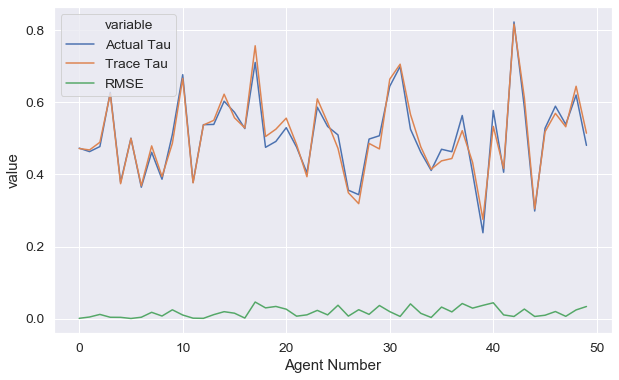

In [43]:
sns.lineplot(x="Agent Number", y="value", hue="variable", data=plot_concat_taus_df);

In [50]:
trace['alpha'].mean()

0.45644960197379175

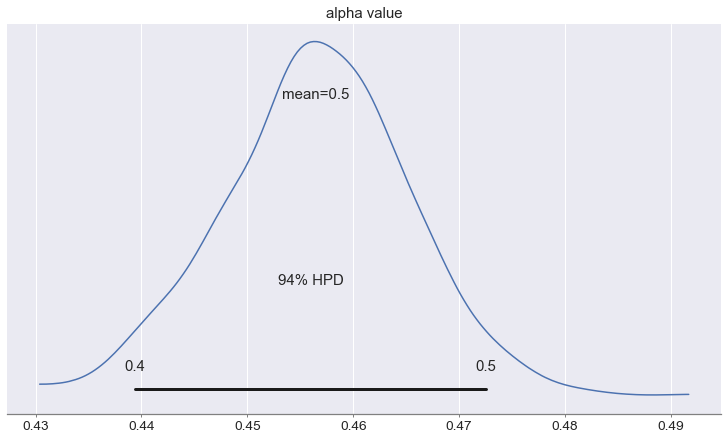

In [52]:
axes = pm.plot_posterior(trace, varnames=["alpha"])
for i, ax in enumerate(axes):
    ax.set_title("alpha value")

In [69]:
coh_matrix_flatten = pd.DataFrame(coh_matrix_df.values.flatten())
coh_matrix_flatten.columns = ['Actual Coh matrix']
trace_mean_theta = pd.DataFrame(pd.DataFrame(trace['theta'].mean(axis=0)).values.flatten())
trace_mean_theta.columns = ['Trace coh matrix']

concat_theta_df = pd.concat([coh_matrix_flatten, trace_mean_theta], axis=1)
concat_theta_df['RMSE'] = ((concat_theta_df['Actual Coh matrix'] - concat_theta_df['Trace coh matrix']) ** 2) ** .5
concat_theta_df['coh_matrix_index'] = ["coh_{}_{}".format(i//16, i%16)  for i in range(256)]
concat_theta_df.head()

,Actual Coh matrix,Trace coh matrix,RMSE,coh_matrix_index
0,0.000000,0.021793,0.021793,coh_0_0
1,0.000000,0.018112,0.018112,coh_0_1
2,0.000000,0.016628,0.016628,coh_0_2
3,0.000000,0.017423,0.017423,coh_0_3
4,0.362204,0.157682,0.204522,coh_0_4


In [71]:
plot_concat_theta_df = concat_theta_df.melt(id_vars=['coh_matrix_index'])

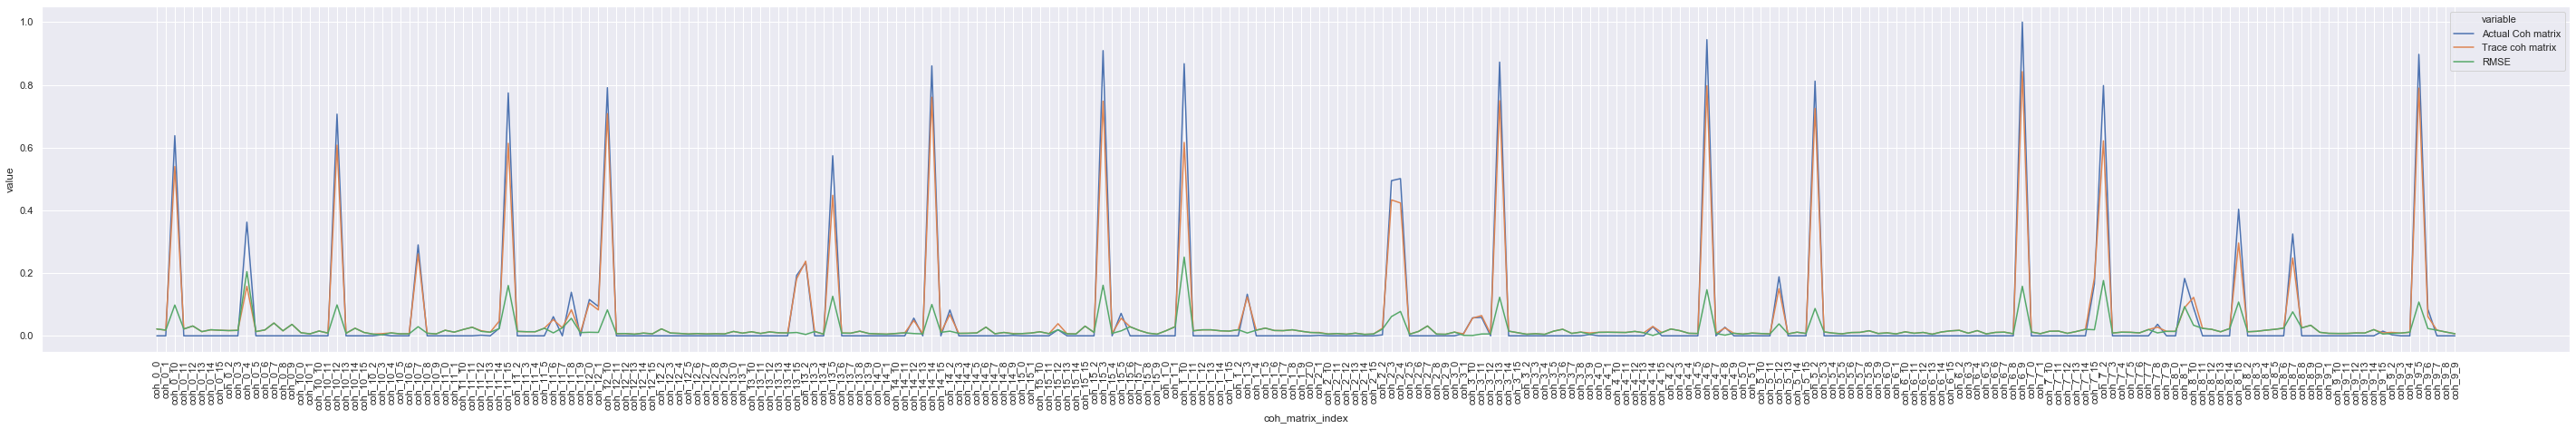

In [81]:
sns.set(rc={'figure.figsize':(50,7)})

sns.lineplot(x="coh_matrix_index", y="value", hue="variable", data=plot_concat_theta_df);
plt.xticks(rotation=90);

In [ ]:
1 / (1 + np.exp(-8*(bits_disagreement-agents_number_list.reshape(-1, 1))))

In [ ]:
np.math.exp(-8*(bits_disagreement-agents_number_list.reshape(-1, 1)))

In [ ]:
agents_number_list.reshape(-1, 1)[0]

In [ ]:
bits_disagreement-agents_number_list.reshape(-1, 1)

In [ ]:
np.true_divide(m, v.reshape(-1, 1))

In [ ]:
np.array([1,2,3,4])*bit_m

In [ ]:
a = np.random.rand(10000)
a[agents_number_list]

In [ ]:
agent_tau_vec = np.random.rand(100)
tau_vals = agent_tau_vec[agents_number_list]
reshape_tau_vals = tau_vals.reshape((-1, 1))
r = 1 / (1 + np.exp(-8*(bits_disagreement-reshape_tau_vals)))
m =  r.reshape((-1, 1, 4))
tc = np.dot(m, bit_m.T)
tm = tc.reshape((-1, 16))

In [ ]:
tm